In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
'''
データのロード
'''
data=pd.read_csv('sales_train.csv.gz')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [12]:
data.head()

date
2013-01-01    1951.0
2013-01-02    3817.0
2013-01-03    3846.0
2013-01-04    2574.0
2013-01-05    4863.0
Freq: D, Name: item_cnt_day, dtype: float64

In [0]:
'''
クリーニング
'''
# object -> datetime
data['date'] = pd.to_datetime(data['date'])

In [0]:
# date => index
data.set_index(['date'],inplace=True)

In [0]:
# hourly data -> dayly data
data = data['item_cnt_day'].resample('D').sum()
df = pd.DataFrame(data)

In [17]:
df.head()

,item_cnt_day
date,
2013-01-01,1951.0
2013-01-02,3817.0
2013-01-03,3846.0
2013-01-04,2574.0
2013-01-05,4863.0


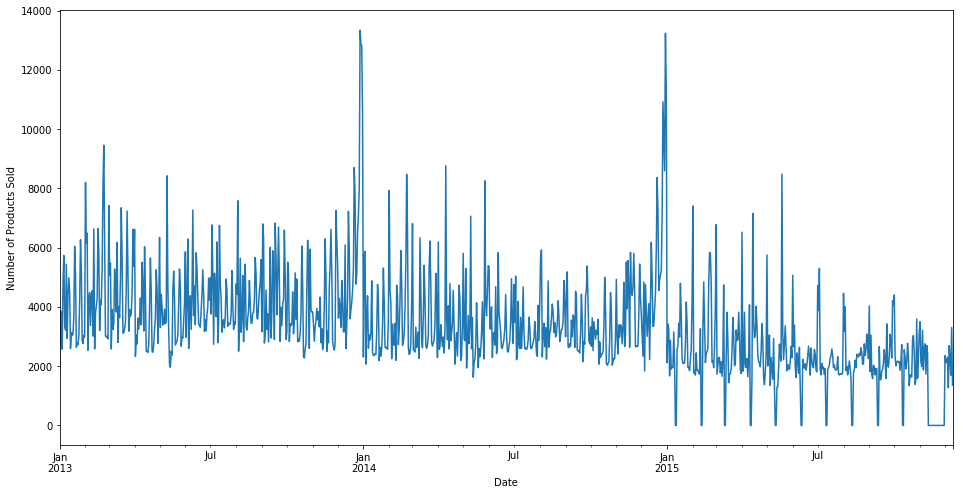

In [18]:
plt.figure(figsize=(16,8))
df['item_cnt_day'].plot()
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

In [0]:
'''
正規化
'''
df_1 = df.values
df_1 = df_1.astype('float32')

scalar = MinMaxScaler(feature_range=(-1, 1))
ts = scalar.fit_transform(df_1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2013-01-01 to 2015-12-10
Freq: D
Data columns (total 1 columns):
item_cnt_day    1074 non-null float64
dtypes: float64(1)
memory usage: 56.8 KB


In [0]:
'''
モデルの構築
'''
timestep = 30
X = []
Y = []

raw_data = ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 850
Xtrain = X[:k,:,:]  
Ytrain = Y[:k]

In [27]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(30, 1)))
model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=8, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, Ytrain, epochs=1000, verbose=0)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
Xtest = X[k:,:,:]  
Ytest= Y[k:]  

In [31]:
preds = model.predict(Xtest)
preds = scalar.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scalar.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scalar.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)


1969860.0

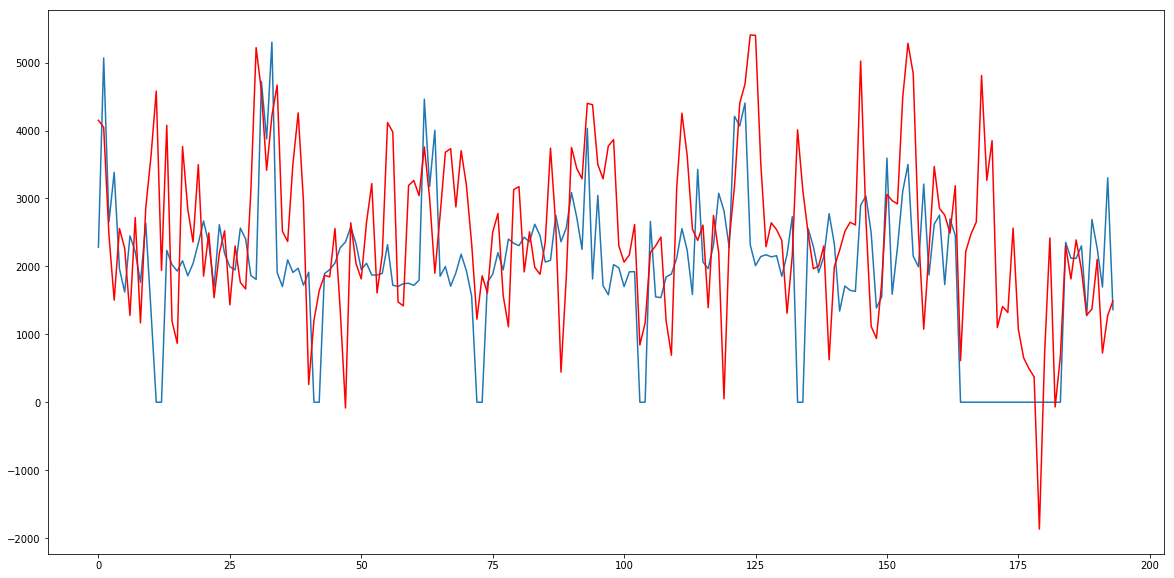

In [32]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()
